<a href="https://colab.research.google.com/github/newalchemy/personal_test/blob/main/MNIST_Data_deep_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Deep clustering on MNIST**

This notebook will do the following:    
1.  Implement an auto-encoder on the MNIST dataset.
2.  Perform differential k-means clustering on the bottleneck layer, with K=10
3.  Evaluate the model and discuss the parameters tuned.

The overall approach that I took was to train the auto-encoder first, use t-SNE to verify seperability of the bottleneck layer, and then run differential k-means on the encoded MNIST pictures.  I then used t-SNE to evaluate the output and clusters to further assist in the tuning of hyperparameters.  This is an assignment that I did for a course that I took in graduate school, Deep Learning and Neural Computation.

## **Autoencoding and verification (Part 1/3)**
The code below is the implementation of the autoencoder, and the encoding of the pictures using the bottleneck layer.  Additionally, t-SNE is used at the end to verify that the encoded images are separable.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0
done creating auto-encoder!
done encoding images!


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


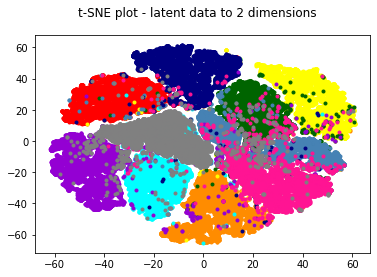

In [ ]:

import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import pickle
import random

from google.colab import drive

from sklearn.manifold import TSNE

from torchvision.utils import save_image

from matplotlib import pyplot as plt


# Bookkeeping for Google Drive
drive.mount('/content/drive');

device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device0)

mnist_loc = '/content/drive/My Drive/MNIST_Data/';

mnist_AE_out_loc = '/content/drive/My Drive/MNIST_AE_Out/';

file_loc = '/content/drive/My Drive/diffKMeans_out/';

tsne_loc = '/content/drive/My Drive/tSNE_Out/';
file_loc = '/content/drive/My Drive/diffKMeans_out/';


num_epochs = 30
batch_size = 256
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = MNIST(mnist_loc, transform=img_transform, download=True);
# dataset = MNIST('C:\\Users\\timhe\\OneDrive\\Documents\\StatsWorkFolder\\CS5525\\MNIST', download=True);
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True);

# I wish I could take credit for this autoencoder.  However, this was the first assignment of the class, and CNNs were not covered yet, so
# the original autoencoder simply flattened the image and passed it through several fully connected layers for the encoder and decoder.
#
# When I revisited this, I decided that a CNN would likely provide much better performance.  
# Instead of reinventing the wheel, I used the autoencoder from here.
#
# https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
          nn.Conv2d(1, 8, 3, stride=2, padding=1),#15
          nn.ReLU(True),
          nn.Conv2d(8, 16, 3, stride=2, padding=1),#9
          nn.BatchNorm2d(16),
          nn.ReLU(True),
          nn.Conv2d(16, 32, 3, stride=2, padding=0),#5     
          nn.ReLU(True),
          nn.Flatten(start_dim=1),
          nn.Linear(32 * 3 * 3, 128),
          nn.ReLU(True),
          nn.Linear(128,4)
        );

        self.decoder = nn.Sequential(
          nn.Linear(4, 128),
          nn.ReLU(True), 
          nn.Linear(128, 3 * 3 * 32),
          nn.ReLU(True),
          nn.Unflatten(dim=1, unflattened_size=(32,3,3)),
          nn.ConvTranspose2d(32,16, 3, stride=2),
          nn.BatchNorm2d(16),
          nn.ReLU(True),
          nn.ConvTranspose2d(16,8,3, stride=2, padding=1, output_padding=1),
          nn.ReLU(True),
          nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        );

    def forward(self, x):
        x = self.encoder(x);
        self.latent = x.clone();
        x = self.decoder(x);
        x = torch.sigmoid(x);
        return x
    
    def getLatentLayer(self):
        return self.latent;

def add_noise(inp_tensor, noise_factor=0.3):
    sx = inp_tensor.size();
    out_tensor = inp_tensor + torch.normal(0, noise_factor, sx);
    return out_tensor;

model = autoencoder();
model = model.to(device0);
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

batch_iter = 0;

num_samp = 0;
losses = [];
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device0);
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch == 0): 
          sx = img.size();
          num_samp = num_samp + sx[0];        
    # ===================log========================
torch.save(model.state_dict(), '{}mnist_autoencoder.pth'.format(file_loc))
print('done creating auto-encoder!')

# Create the encoded images one at a time, and save them in a pickle file in my google drive.
dataloader_2 = DataLoader(dataset, batch_size=1, shuffle=True);

images_reduced = torch.zeros(num_samp, 4);
labels_true = torch.zeros(num_samp, 1);
itr = 0;
for data in dataloader_2:
    img, label = data;
    img = img.to(device0);
    output = model(img);
    img_reduced = model.getLatentLayer();
    images_reduced[itr, :] = img_reduced;
    labels_true[itr] = label;
    itr = itr + 1;

with open(file_loc + 'images_reduced.pickle', 'wb') as handle:
    pickle.dump(images_reduced, handle)

with open(file_loc + 'labels_true.pickle', 'wb') as handle:
    pickle.dump(labels_true, handle)

print('done encoding images!')

with open(file_loc + 'images_reduced.pickle', 'rb') as handle:
    images_reduced = pickle.load(handle)

with open(file_loc + 'labels_true.pickle', 'rb') as handle:
    labels_true = pickle.load(handle)

n_components = 2;
perplexity = 30;
early_exaggeration = 12;
learning_rate = 200;
n_iter = 1000;
n_iter_without_progress = 300;
min_grad_norm = 1e-7;
init='pca'

tsneOut = TSNE(n_components=2).fit_transform(images_reduced.detach().numpy());
#tsneOut = TSNE(n_components=n_components, perplexity=perplexity, early_exaggeration=early_exaggeration, 
#               learning_rate=learning_rate, n_iter=n_iter, n_iter_without_progress=n_iter_without_progress, 
#               min_grad_norm=min_grad_norm, init=init).fit_transform(images_reduced.detach().numpy());
#tsneOut = tsnecuda.TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate).fit_transform(images_reduced.detach().numpy());



with open(file_loc + 'tsneOut.pickle', 'wb') as handle:
    pickle.dump(tsneOut, handle)

#with open(file_loc + 'tsneOut.pickle', 'rb') as handle:
#    tsneOut = pickle.load(handle)

label_colors = ['red', 'darkorange', 'yellow', 'darkgreen', 'cyan', 'steelblue', 'navy', 'darkviolet', 'deeppink', 'grey'];

#Separate the x and y values
xa = tsneOut[:,0];
ya = tsneOut[:,1];

f4 = plt.figure();
f4.suptitle('t-SNE plot - latent data to 2 dimensions');

for itr in range(10):
    myColor = label_colors[itr];
    myLabel_inxs = [i for i, val in enumerate(labels_true) if val==itr];

    x_lab = xa[myLabel_inxs];
    y_lab = ya[myLabel_inxs];

    plt.scatter(x_lab, y_lab, c=myColor, axes=f4.gca(), marker='.');

path = '{}{}.png'.format(tsne_loc, 'TSNE_Plot');
f4.savefig(fname=path);


Encode all of the images into the latent layer of the auto-encoder, and save off the images in a pickle file.

## **Differential K Means (Part 2/3)**

Differential K means is performed by starting with K initial clusters, and then performing gradient descent to move the cluster centers to their optimal locations.  All points are assigned a label based on which cluster they are closest to.

The loss function, without penalization, is defined as the following:

$$ Loss = \Sigma_x\Sigma_kD .* W $$

Where:     

**D**: A *num_samples x K* matrix which contains the euclidean distance squared between each point and each cluster center.

**.***:  Pointwise matrix multiplication.

**W**:  A *num_samples x K* matrix which contains the probability that each point belongs in each cluster.  Each row sums to 1.  It is computed based off of the following equation:

$$ W_{xc} = \frac{exp(-D_{xc}/BANDWIDTH)}{\Sigma_cexp(-D_{xc}/BANDWIDTH)}$$ 

where D is the matrix defined above, and BANDWIDTH is a hyperparameter, x is a point, and c is a cluster center.  

This equation means that each entry in W is defined as the gaussian transformation of the euclidean distance squared between that point and its cluster center, normalized to the gaussian transformation between that point and all other clusters.  

### **Penalization Term**

I decided to introduce a penalization term in order to disincentivize the algorithm from landing on local minima where multiple cluster centers happened to be close together, since minima with clusters closer together generally results in lower accuracy scores for the output.  

The penalization term is defined as:     

$$ P = C*\Sigma_{k>i\ge 0}\Sigma_{k>j>i}\frac{1}{||c_i - c_j||_2^2}$$

This equation means that the euclidean distance between each cluster center is squared, has its reciprocal taken, and is added together and multipled by a constant C, which is a hyperparameter.

This penalization, with hyperparameter C=10, gave a 2% increase in the accuracy of the results.

### **Cluster Initialization**
The initial clusters are defined in this way:     

1. Choose one of the points passed to the algorithm at random.  That is the first cluster center.

2.  For each point that is not a cluster center, take the euclidean distance between itself and the current cluster centers.  Then, keep the smallest of those distances computed, and do that for each point.  The value D(x), for a given point x, will be that "largest smallest distance".

3.  Choose the next cluster center randomly, where each point x has the probability listed below of being selected:

$$ P(x) = \frac{D(x)^2}{\Sigma_x{D(x)^2}} $$

This is the k-means++ initialization algorithm, which is currently very popular and known to produce very good results.  

### **Hyperparameters**

The hyperparameters for this algorithm are:     

**K**:  The number of clusters, predefined by the assignment (10).

**Bandwidth**:  The Bandwidth of the RBF Gaussian Kernel used to generate W.

**learning_rate**: Update rate for each timestep.

**num_epochs**:   How many epochs to compute the gradient for.

**C**:    The weight to put on the penalization term.


Mounted at /content/drive
cuda:0
images reduced size: torch.Size([60000, 4])


iters: 0 , loss: 45677.828125 , accuracy: 64.55499999999999 

iters: 1 , loss: 40058.15625 , accuracy: 64.80333333333334 

iters: 2 , loss: 36869.6328125 , accuracy: 64.905 

iters: 3 , loss: 34987.421875 , accuracy: 65.04833333333333 

iters: 4 , loss: 33776.9453125 , accuracy: 65.2 

iters: 5 , loss: 32922.17578125 , accuracy: 65.36999999999999 

iters: 6 , loss: 32269.1953125 , accuracy: 65.52 

iters: 7 , loss: 31743.388671875 , accuracy: 65.67333333333333 

iters: 8 , loss: 31307.3984375 , accuracy: 65.91833333333334 

iters: 9 , loss: 30940.7109375 , accuracy: 66.05 

iters: 10 , loss: 30630.130859375 , accuracy: 66.24666666666667 

iters: 11 , loss: 30366.169921875 , accuracy: 66.38166666666667 

iters: 12 , loss: 30141.873046875 , accuracy: 66.5 

iters: 13 , loss: 29951.830078125 , accuracy: 66.58 

iters: 14 , loss: 29791.361328125 , accuracy: 66.635 

iters: 15 , loss: 29656.20703125 , accuracy: 6

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


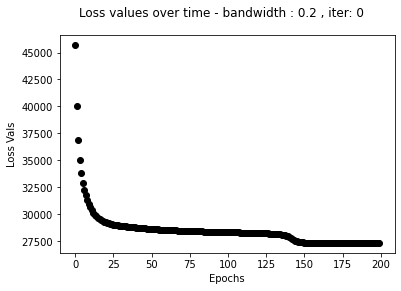

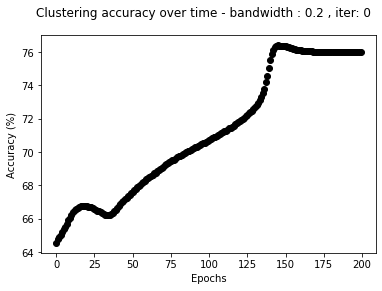

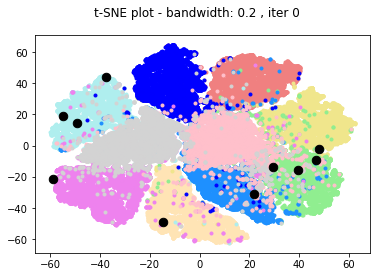

In [ ]:
# -*- coding: utf-8 -*-

import torch
import pickle

from matplotlib import pyplot
# from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

from torchvision.datasets import MNIST

import numpy as np
import gc
import logging
import random

from scipy.optimize import linear_sum_assignment as linear_assignment

from google.colab import drive

from sklearn.manifold import TSNE

drive.mount('/content/drive');

device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device0)

mnist_loc = '/content/drive/My Drive/MNIST_Data/';

file_loc = '/content/drive/My Drive/diffKMeans_out/';


def diffKMeans(X, labels_true, K, BANDWIDTH, num_epochs, learning_rate, device):
    
    sx = X.size();
    num_samples = sx[0];
    num_dim = sx[1];
    
    # Initialize clusters
    U_initialClusters = initializeKMeansPoints(X,K,device);
    U_vals = U_initialClusters.detach_().clone();
    cluster_centers_over_time = torch.zeros(num_epochs, K, num_dim);
    cluster_centers_over_time[0,:,:] = U_initialClusters.detach_().clone();
    
    # U_vals is the variable we will be performing gradient descent on.
    U_vals.requires_grad_(True);
    U_vals = U_vals.to(device);


    iters = 0;

    loss_vals_over_time = [];
    scores_over_time = [];
    labels_over_time = torch.zeros(num_epochs, num_samples);
    
    iters = 0;
    while iters < num_epochs:
        
        # D is a num_samples x K matrix, which contains the distance between each point and each cluster.
        # The distance measure is euclidean distance, squared.
        D = torch.zeros(num_samples, K, device=device);
        for p in range(num_samples):
            myP = X[p,:];
            for c in range(K):
                myC = U_vals[c,:];
                dist = (myP - myC) ** 2;

                D[p,c] = torch.sum(dist, dim=0);
                #D[p,c] = dist.sum(dim=0);
        
        if (iters % 25 == 0):
            with open('/content/drive/My Drive/diffKMeans_out/' + 'D_{}.pickle'.format(iters), 'wb') as handle:
                D_out = D.clone();
                D_out = D_out.to('cpu');
                pickle.dump(D_out, handle);
                del D_out
        
        # W is a num_samples x K matrix which contains, for each point, the probability that 
        # the point belongs to a specific cluster.
        # It is a direct function of how far away each point is from the given cluster.  
        # It uses a RBF Gaussian Kernel, then normalizes it so it turns into a set of probabilities.  
        # Each row in the W matrix sums to 1. 
        G = torch.exp(-D/BANDWIDTH);
        G_sum = torch.sum(G, dim=1);
        W = torch.zeros(num_samples, K, device=device);

        for l in range(K):
            W[:,l] = G[:,l] / G_sum
            
            if (iters % 25 == 0):
                with open('/content/drive/My Drive/diffKMeans_out/' + 'cluster_centers_{}.pickle'.format(iters), 'wb') as handle:
                    cluster_clone = cluster_centers_over_time.clone();
                    cluster_clone = cluster_clone.to('cpu');
                    pickle.dump(cluster_clone, handle);
                    del cluster_clone

                with open('/content/drive/My Drive/diffKMeans_out/' + 'labels_over_time_{}.pickle'.format(iters), 'wb') as handle:
                    labels_clone = labels_over_time.clone();
                    labels_clone = labels_clone.to('cpu');
                    pickle.dump(labels_clone, handle)
                    del labels_clone

         #This was my penalty function which was used to penalize clusters which are too close to each other.
        P = torch.zeros(K, K);
        for i in range(K):
            myP = U_vals[i, :];
            for j in range(i + 1, K):
                curP = U_vals[j, :];
                diff = 1/torch.sum((myP - curP) ** 2);
                P[i,j] = diff;


        # Performing the back propogation and gradient descent.
        F = D * W;
        #loss = torch.sum(torch.sum(F, dim=1), dim=0);
        loss = torch.sum(torch.sum(F, dim=1), dim=0) + 10*torch.sum(torch.sum(P, dim=1), dim=0);
        loss.backward();
    
        U_vals.data = U_vals.data - learning_rate*U_vals.grad.data/num_samples;

        U_vals.grad.zero_();
        U_vals.requires_grad_(True);
        
        # Bookkeeping of certain variables/information for analysis later.
        loss_clone = loss.clone().detach_().to('cpu');
        loss_vals_over_time.append(loss_clone);
        
        cluster_centers_over_time[iters,:,:] = U_vals.data.clone();
        for ns in range(num_samples):
            myI = W[ns,:];
            m = torch.argmax(myI);
            labels_over_time[iters, ns] = m.int();

        labels_now = labels_over_time[iters, :];
        score_now = cluster_acc(np.asarray(labels_true), labels_now.int().detach().numpy()) * 100;
        scores_over_time.append(score_now);
        print("iters: {} , loss: {} , accuracy: {} \n".format(iters, loss, score_now));
        iters = iters + 1;

    with open('/content/drive/My Drive/diffKMeans_out/' + 'cluster_centers.pickle', 'wb') as handle:
        pickle.dump(cluster_centers_over_time, handle)

    with open('/content/drive/My Drive/diffKMeans_out/' + 'labels_over_time.pickle', 'wb') as handle:
        pickle.dump(labels_over_time, handle)

    return scores_over_time, labels_over_time, cluster_centers_over_time, loss_vals_over_time;


def initializeKMeansPoints(X, K, device):
    sx = X.size();
    num_s = sx[0];
    dim = sx[1];
    
    U_ret = torch.zeros(K, dim, device=device);
    
    
    distMat = torch.zeros(num_s, K, device=device)


    for i in range(K - 1):
        if (i == 0):
            initInx = torch.rand(1, device=device)*num_s;
            initInx.round_();
    
            firstPoint = X[initInx.long(),:];
            U_ret[0,:] = firstPoint;

        myP = U_ret[i,:];
        
        dist = (X - myP) ** 2;
        dist = dist.sum(dim=1);
        distMat[:,i] = dist;

        mVec_o = torch.zeros(num_s, 1, device=device);

        for n in range(num_s):
            myR = distMat[n,0:i+1];
            val = torch.min(myR);
            mVec_o[n,0] = val;
                  
        # j = torch.argmax(mVec_o);
        total = torch.sum(mVec_o, dim=0);
        frac = mVec_o / total;
        pdf = frac.transpose(0,1).cpu().numpy()[0];
        inxs = np.array([i for i in range(num_s)]);
        j = np.random.choice(inxs, p=pdf);

        U_ret[i + 1, :] = X[j,:];
    return U_ret;

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy.
    (Taken from https://github.com/XifengGuo/IDEC-toy/blob/master/DEC.py)
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w) # Optimal label mapping based on the Hungarian algorithm
    
    return sum(w[ind[0][i], ind[1][i]] for i in range(len(ind[0]))) * 1.0 / y_pred.size


with open(file_loc + 'images_reduced.pickle', 'rb') as handle:
    images_reduced = pickle.load(handle)

with open(file_loc + 'labels_true.pickle', 'rb') as handle:
    labels_true = pickle.load(handle)

num_epochs = 200;
K = 10;
learning_rate = 1;

print('images reduced size:', images_reduced.size());
print("\n");

num_samp = len(images_reduced[:, 0]);
num_test = int(num_samp * 0.2);
# To save processing time, only run the diff k means on a random 20% of the test set.
random.seed(250);
test_inxes = [random.randint(0, num_samp) for i in range(num_test)];

with open(file_loc + 'test_inxes.pickle', 'wb') as handle:
    pickle.dump(test_inxes, handle)

#images_test = images_reduced[test_inxes, :];
#labels_test = labels_true[test_inxes];
images_test = images_reduced;
labels_test = labels_true;

#Convert the images to a lower dimensional form
num_iterations = 1;
curIter = 0;
BANDWIDTH = 0.2;
images_test.detach_();
images_test = images_test.to(device0);
while (curIter < num_iterations):
    scores_over_time, labels_over_time, cluster_centers_over_time, loss_vals_over_time = diffKMeans(images_test, labels_test, K, BANDWIDTH, num_epochs, learning_rate, device0);
    print("curIter: \n", curIter); 

    epochs = [i for i in range(num_epochs)];

    bandw_str = '{}'.format(BANDWIDTH).replace('.', 'p');

    f2 = pyplot.figure();
    pyplot.scatter(x=epochs, y=loss_vals_over_time, c='k', axes = f2.gca(), marker='o');
    path = '{}{}{}{}{}.png'.format(file_loc, 'Losses_BAND_', bandw_str, 'iter', curIter);
    pyplot.xlabel('Epochs');
    pyplot.ylabel('Loss Vals');
    f2.suptitle('Loss values over time - bandwidth : {} , iter: {}'.format(BANDWIDTH, curIter));
    f2.savefig(fname=path);

    f3 = pyplot.figure();
    pyplot.scatter(x=epochs, y=scores_over_time, c='k', axes = f3.gca(), marker='o');
    path = '{}{}{}{}{}.png'.format(file_loc, 'ClusterAccuracy_BAND_', BANDWIDTH, 'iter', curIter);
    pyplot.xlabel('Epochs');
    pyplot.ylabel('Accuracy (%)');
    f3.suptitle('Clustering accuracy over time - bandwidth : {} , iter: {}'.format(BANDWIDTH, curIter));
    f3.savefig(fname=path);

    num_test = int(len(test_inxes) * 0.2);
    n_components = 2;
    perplexity = 30;
    early_exaggeration = 12;
    learning_rate = 200;
    n_iter = 1000;
    n_iter_without_progress = 300;
    min_grad_norm = 1e-7;
    init='pca';

    images_test_clone = images_test.clone().detach_().to('cpu')

    myinx = num_epochs - 1;
    out_centers = cluster_centers_over_time[myinx,:,:];
    out_centers_n = out_centers.clone().detach_().to('cpu');
    images_test_clone = torch.cat((images_test_clone, out_centers_n), 0);

    tsneOut = TSNE(n_components=n_components, perplexity=perplexity, early_exaggeration=early_exaggeration, 
               learning_rate=learning_rate, n_iter=n_iter, n_iter_without_progress=n_iter_without_progress, 
               min_grad_norm=min_grad_norm, init=init).fit_transform(images_test_clone.detach().numpy());

    xa = tsneOut[:,0];
    ya = tsneOut[:,1];

    x_lab = xa[0:num_test];
    y_lab = ya[0:num_test];

    label_inx = num_test;
    label_colors = ['lightcoral', 'moccasin', 'khaki', 'lightgreen', 'paleturquoise', 'dodgerblue', 'blue', 'violet', 'pink', 'lightgrey'];

    cluster_colors = 'black';

    f4 = pyplot.figure();
    f4.suptitle('t-SNE plot - bandwidth: {} , iter {}'.format(BANDWIDTH, curIter));

    for itr in range(10):
        myColor = label_colors[itr];
        myLabel_inxs = [i for i, val in enumerate(labels_test) if val==itr];

        x_lab = xa[myLabel_inxs];
        y_lab = ya[myLabel_inxs];

        pyplot.scatter(x_lab, y_lab, c=myColor, axes=f4.gca(), marker='.');

    x_cluster = xa[label_inx:label_inx+K];
    y_cluster = ya[label_inx:label_inx+K];

    pyplot.scatter(x_cluster, y_cluster, c=cluster_colors, axes=f4.gca(), marker='o', s=72);

    path = '{}{}{}{}{}.png'.format(file_loc, 'TSNE_Plot_BANDWIDTH_', bandw_str, '_iter_', curIter);
    f4.savefig(fname=path);

    curIter = curIter + 1;


## **Differential K Means Results and Analysis (Part 3/3)**

Overall, the algorithm produces a clustering accuracy of about 78% across the entire MNIST dataset.  The optimal bandwidth is about 0.1.  This means that most of the time, the closest cluster cluster to a given point is assigned a probability of 1 on each iteration, and all other cluster centers are assigned a probability of 0.  

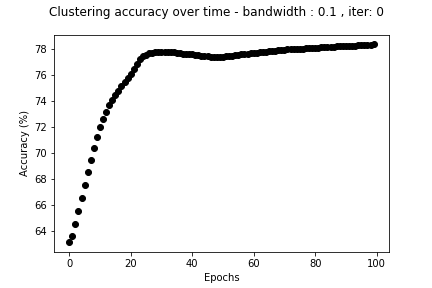

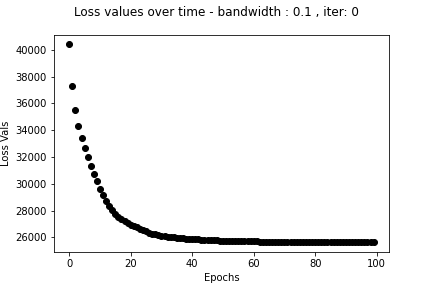

I also used t-SNE to plot the data with the chosen cluster centers, but found that method much less useful.


In general, performance is bounded by:     

1. The imperfect dimensionality reduction performed by the autoencoder, as demonstrated in the t-SNE plot.

2.  The fact that k-means assumes that the natural clusters in the data are spherical and non-overlapping, which I highly doubt is the case here.  

3.  The performance may be able to be improved by a better autoencoder.